In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torchvision

from torchvision import datasets
from torchvision import transforms
from torchvision.utils import make_grid

from tqdm import tqdm
#from torchinfo import summary

import numpy as np
import matplotlib.pyplot as plt


In [2]:
print('GPU name:', torch.cuda.get_device_name(), '\n')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

GPU name: NVIDIA A100-PCIE-40GB 



'cuda'

# Load MNIST dataset


In [3]:
rotation = 10
translation = (0.1, 0.1)
scaling = (0.9, 1.1)
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.RandomAffine(degrees=[-rotation, rotation], 
                                                        translate=translation, 
                                                        scale=scaling),
    
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])
test_transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=(0.5,), std=(0.5,))])


training_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=test_transform)

# Define dataloaders


In [4]:

batch = 100

training_dataloader = DataLoader(training_dataset, batch_size=batch, shuffle=True, drop_last=True,num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch, shuffle=False, drop_last=True,num_workers=4)

(-0.5, 273.5, 443.5, -0.5)

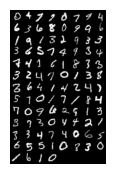

In [5]:
images = next(iter(training_dataloader))[0]
images = next(iter(training_dataloader))[0]

grid = make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(12, 2))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

# Define Linear_Variance_Scheduler


In [6]:
class Linear_Variance_Scheduler:
    def __init__(self, time_steps, beta_start, beta_end, device='cuda'):
        
        self.time_steps = time_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.device = device
        
        self.betas = torch.linspace(self.beta_start, self.beta_end, self.time_steps).to(self.device)
        self.alphas = 1 - self.betas
        self.alpha_bar = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_bar = torch.sqrt(self.alpha_bar)
        self.sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar)
        
    def diffusion_process(self, x, noise, t):
        t = torch.clamp(t, max=self.time_steps - 1)  # Ensure t is within bounds
        sqrt_alpha_bar = self.sqrt_alpha_bar[t][:, None, None, None]
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_bar[t][:, None, None, None]
        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise
    
    # Reverse process
    def ddpm_sampling(self, model, num_samples,sample_steps, channels, img_size, wanted_class=None):
        model.eval()
        model = model.to(self.device)
        wanted_class = wanted_class.to(self.device)
        with torch.inference_mode():
            x = torch.randn((num_samples, channels, img_size, img_size)).to(self.device)
            collect = {}
            for i in tqdm(reversed(range(self.time_steps))):
                t = (torch.ones(num_samples) * i).long().to(self.device)
                pred_noise = {}

                if wanted_class is not None:
                    pred_noise = model(x, wanted_class,t)
                else:
                    pred_noise = model(x, t)
                alphas = self.alphas[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                betas = self.betas[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = 1 / torch.sqrt(alphas) * (x - ((1 - alphas) / (torch.sqrt(1 - alpha_bar))) * pred_noise) +\
                    torch.sqrt(betas) * noise
                if i in sample_steps:
                    collect[i] = x.detach().cpu()
        return x, collect

# Forward process output


In [7]:
t_step = torch.linspace(start=0, end=1000-1, steps=11).long()
get_img = training_dataset[0][0]

get_img_stack = torch.stack([get_img]*11)
get_noise_stack = torch.randn_like(get_img_stack)

In [8]:
noisy_img_stack = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02,
                                            device='cpu').diffusion_process(get_img_stack, get_noise_stack, t_step)

### Play with forward parameters

#### U-net Architecture:
- Resblock
- SelfAttentionBlock
- Downblock
- Upblock

# Create ResBlock

In [9]:
class ResBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, mid_ch=None, residual=False):
        super(ResBlock, self).__init__()
        
        self.residual = residual
        if not mid_ch:
            mid_ch = out_ch
        self.resnet_conv = nn.Sequential()
        self.resnet_conv.add_module('conv1', nn.Conv2d(in_channels=inp_ch, out_channels=mid_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor1', nn.GroupNorm(num_groups=8, num_channels=mid_ch))
        self.resnet_conv.add_module('silu1', nn.SiLU())
        self.resnet_conv.add_module('conv2', nn.Conv2d(in_channels=mid_ch, out_channels=out_ch, kernel_size=3, stride=1,
                                                       padding=1))
        self.resnet_conv.add_module('gnor2', nn.GroupNorm(num_groups=8, num_channels=out_ch))
        
    def forward(self, x):
        if self.residual:
            return x + self.resnet_conv(x)
        else:
            return self.resnet_conv(x)

# Create SelfAttentionBlock

In [10]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, channels):
        super(SelfAttentionBlock, self).__init__()
        
        self.attn_norm = nn.GroupNorm(num_groups=8, num_channels=channels)
        self.mha = nn.MultiheadAttention(embed_dim=channels, num_heads=4, batch_first=True)
        
    def forward(self, x):
        b, c, h, w = x.shape
        inp_attn = x.reshape(b, c, h*w)
        inp_attn = self.attn_norm(inp_attn)
        inp_attn = inp_attn.transpose(1, 2)
        out_attn, _ = self.mha(inp_attn, inp_attn, inp_attn)
        out_attn = out_attn.transpose(1, 2).reshape(b, c, h, w)
        return x + out_attn

# Create DownBlock

In [11]:
class DownBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(DownBlock, self).__init__()
        
        self.down = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, t):
        x = self.down(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UpBlock

In [12]:
class UpBlock(nn.Module):
    def __init__(self, inp_ch, out_ch, t_emb_dim=256):
        super(UpBlock, self).__init__()
        
        self.upsamp = nn.UpsamplingBilinear2d(scale_factor=2)
        self.up = nn.Sequential(
            ResBlock(inp_ch=inp_ch, out_ch=inp_ch, residual=True),
            ResBlock(inp_ch=inp_ch, out_ch=out_ch, mid_ch=inp_ch//2)
        )
        
        self.t_emb_layers = nn.Sequential()
        self.t_emb_layers.add_module('silu1', nn.SiLU())
        self.t_emb_layers.add_module('linr1', nn.Linear(in_features=t_emb_dim, out_features=out_ch))
        
    def forward(self, x, skip, t):
        x = self.upsamp(x)
        x = torch.cat([skip, x], dim=1)
        x = self.up(x)
        t_emb = self.t_emb_layers(t)[:, :, None, None].repeat(1, 1, x.shape[2], x.shape[3])
        return x + t_emb

# Create UNet

In [13]:
class UNet(nn.Module):
    def __init__(self, t_emb_dim, device='cuda'):
        super(UNet, self).__init__()
        
        self.device = device
        self.t_emb_dim = t_emb_dim
        
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)
        
        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)
        
        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)
        
        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)
        
    def position_embeddings(self, t, channels):
        i = 1 / (10000 ** (torch.arange(start=0, end=channels, step=2) / channels))
        pos_emb_sin = torch.sin(t.repeat(1, channels//2) * i)
        pos_emb_cos = torch.cos(t.repeat(1, channels//2) * i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb
    
    def forward(self, x, t):
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)
        
        x1 = self.inp(x)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        
        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)
        
        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output

# FiLM layer for conditional training

In [14]:


class FiLM(nn.Module):
    def __init__(self, in_channels, embedding_dim):
        super(FiLM, self).__init__()
        self.gamma = nn.Linear(embedding_dim, in_channels)
        self.beta = nn.Linear(embedding_dim, in_channels)

    def forward(self, x, embedding):
        gamma = self.gamma(embedding).unsqueeze(-1).unsqueeze(-1)
        beta = self.beta(embedding).unsqueeze(-1).unsqueeze(-1)
        return gamma * x + beta


# Conditional Unet

In [15]:
class CondUNet(nn.Module):
    def __init__(self, t_emb_dim, num_classes=10, class_embedding_size=3, device='cuda'):
        super(CondUNet, self).__init__()
        self.device = device
        self.t_emb_dim = t_emb_dim

        # Class embedding layer
        self.class_embedding = nn.Embedding(num_classes, class_embedding_size)

        # Define your blocks
        self.inp = ResBlock(inp_ch=1, out_ch=64)
        self.down1 = DownBlock(inp_ch=64, out_ch=128)
        self.sa1 = SelfAttentionBlock(channels=128)
        self.down2 = DownBlock(inp_ch=128, out_ch=256)
        self.sa2 = SelfAttentionBlock(channels=256)
        self.down3 = DownBlock(inp_ch=256, out_ch=256)
        self.sa3 = SelfAttentionBlock(channels=256)

        self.lat1 = ResBlock(inp_ch=256, out_ch=512)
        self.lat2 = ResBlock(inp_ch=512, out_ch=512)
        self.lat3 = ResBlock(inp_ch=512, out_ch=256)

        self.up1 = UpBlock(inp_ch=512, out_ch=128)
        self.sa4 = SelfAttentionBlock(channels=128)
        self.up2 = UpBlock(inp_ch=256, out_ch=64)
        self.sa5 = SelfAttentionBlock(channels=64)
        self.up3 = UpBlock(inp_ch=128, out_ch=64)
        self.sa6 = SelfAttentionBlock(channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

        # FiLM layers
        self.film1 = FiLM(in_channels=64, embedding_dim=class_embedding_size)
        self.film2 = FiLM(in_channels=128, embedding_dim=class_embedding_size)
        self.film3 = FiLM(in_channels=256, embedding_dim=class_embedding_size)
        self.film4 = FiLM(in_channels=256, embedding_dim=class_embedding_size)
        self.film5 = FiLM(in_channels=128, embedding_dim=class_embedding_size)
        self.film6 = FiLM(in_channels=64, embedding_dim=class_embedding_size)

        # Positional embedding
        self.pos_embedding_i = 1 / (10000 ** (torch.arange(start=0, end=t_emb_dim, step=2) / t_emb_dim)).to(self.device)

    def position_embeddings(self, t, channels):
        pos_emb_sin = torch.sin(t.repeat(1, channels // 2) * self.pos_embedding_i)
        pos_emb_cos = torch.cos(t.repeat(1, channels // 2) * self.pos_embedding_i)
        pos_emb = torch.cat([pos_emb_sin, pos_emb_cos], dim=-1)
        return pos_emb

    def forward(self, x, label, t):
        bs, _, w, h = x.shape

        # Obtain class embedding
        class_cond = self.class_embedding(label)

        # Time embedding
        t = t.unsqueeze(1).float()
        t = self.position_embeddings(t, self.t_emb_dim)

        # Forward pass with FiLM conditioning
        x1 = self.inp(x)
        x1 = self.film1(x1, class_cond)
        x2 = self.down1(x1, t)
        x2 = self.sa1(x2)
        x2 = self.film2(x2, class_cond)
        x3 = self.down2(x2, t)
        x3 = self.sa2(x3)
        x3 = self.film3(x3, class_cond)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)
        x4 = self.film4(x4, class_cond)

        x4 = self.lat1(x4)
        x4 = self.lat2(x4)
        x4 = self.lat3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.film5(x, class_cond)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.film6(x, class_cond)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.out(x)
        return output


In [22]:
def initialize_weights(m):
    if isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.MultiheadAttention):
        # in_proj_weight and in_proj_bias contains K, V and Q weights concatenated together for weights and biases.
        # so this initializes all the weights.
        nn.init.xavier_normal_(m.in_proj_weight)
        if m.in_proj_bias is not None:
            nn.init.constant_(m.in_proj_bias, 0)
        # The same for m.out_proj.weight an bias
        nn.init.xavier_normal_(m.out_proj.weight)
        if m.out_proj.bias is not None:
            nn.init.constant_(m.out_proj.bias, 0)
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)



In [23]:
from torchinfo import summary

# summary(CondUNet(t_emb_dim=256), input_size=[(64, 1+3, 32, 32), (64,)])


# SET-UP

In [ ]:

ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02)
model = CondUNet(t_emb_dim=256, num_classes=10, class_embedding_size=5).to(device)
model = model.apply(initialize_weights)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# TRAINING

In [25]:
torch.manual_seed(1111)
torch.cuda.manual_seed(1111)
torch.cuda.manual_seed_all(1111)
np.random.seed(1111)

n_epochs = 30
training_loss, test_loss,generated_cpu, fid_scores = [], [],  [], []

for epoch in range(n_epochs):
    average_training_loss, test_losses = 0, 0
    
    for data, label in tqdm(training_dataloader):
        model.train()
        data = data.to(device)
        label = label.to(device)
        t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
        noise = torch.randn_like(data)
        xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
        pred_noise = model(xt, label,t)
        trng_batch_loss = criterion(noise, pred_noise)
        optimizer.zero_grad()
        trng_batch_loss.backward()
        optimizer.step()
        average_training_loss += trng_batch_loss.item()
    training_per_epoch_loss = average_training_loss / len(training_dataloader)
    
    model.eval()
    with torch.inference_mode():
        for data, label in tqdm(test_dataloader):
            data = data.to(device)
            label = label.to(device)
            t = torch.randint(low=0, high=1000, size=(data.shape[0],)).to(device)
            noise = torch.randn_like(data)
            xt = ddpm.diffusion_process(x=data, noise=noise, t=t)
            pred_noise = model(xt,label, t)
            tst_batch_loss = criterion(noise, pred_noise)
            test_losses += tst_batch_loss.item()
        test_per_epoch_loss = test_losses / len(test_dataloader)

    training_loss.append(training_per_epoch_loss)
    test_loss.append(test_per_epoch_loss)
    
    print(f'Epoch: {epoch+1}/{n_epochs}\t| Training loss: {training_per_epoch_loss:.4f} |   ', end='')
    print(f'Test loss: {test_per_epoch_loss:.4f}')
    


  0%|          | 0/600 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


Epoch: 1/30	| Training loss: 0.1243 |   Test loss: 0.0475


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


Epoch: 2/30	| Training loss: 0.0457 |   Test loss: 0.0367


100%|██████████| 100/100 [00:09<00:00, 10.20it/s]


Epoch: 3/30	| Training loss: 0.0389 |   Test loss: 0.0324


100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


Epoch: 4/30	| Training loss: 0.0355 |   Test loss: 0.0286


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


Epoch: 5/30	| Training loss: 0.0333 |   Test loss: 0.0287


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


Epoch: 6/30	| Training loss: 0.0315 |   Test loss: 0.0263


100%|██████████| 100/100 [00:09<00:00, 10.34it/s]


Epoch: 7/30	| Training loss: 0.0311 |   Test loss: 0.0254


100%|██████████| 100/100 [00:09<00:00, 10.24it/s]


Epoch: 8/30	| Training loss: 0.0299 |   Test loss: 0.0243


100%|██████████| 100/100 [00:09<00:00, 10.33it/s]


Epoch: 9/30	| Training loss: 0.0291 |   Test loss: 0.0248


100%|██████████| 100/100 [00:09<00:00, 10.19it/s]


Epoch: 10/30	| Training loss: 0.0286 |   Test loss: 0.0246


100%|██████████| 100/100 [00:09<00:00, 10.22it/s]


Epoch: 11/30	| Training loss: 0.0284 |   Test loss: 0.0237


  4%|▎         | 22/600 [00:05<02:18,  4.18it/s]


KeyboardInterrupt: 

# Save model

In [26]:
# Save the model
torch.save(model.state_dict(), 'ddpm_cond_unet_w_FiLM.pth')

# Load model

In [ ]:
# model = CondUNet(t_emb_dim=256, num_classes=10, class_embedding_size=5, device='cuda')
# # Load the saved state dictionary
# model.load_state_dict(torch.load('ddpm_cond_unet.pth'))

# # Set the model to evaluation mode
# model.eval()

# Plot losses

# Reverse process

In [33]:
steps = [999, 900, 800, 700, 600, 500, 400, 300, 200, 100, 1]


ddpm = Linear_Variance_Scheduler(time_steps=1000, beta_start=0.0001, beta_end=0.02, device='cuda')
model = model.to('cuda')
_, collect = ddpm.ddpm_sampling(
    model=model, 
    num_samples=1,
    sample_steps=steps, 
    channels=1, 
    img_size=32, 
    wanted_class=torch.tensor([2], device='cuda'))


0it [00:00, ?it/s]

1000it [00:07, 128.55it/s]


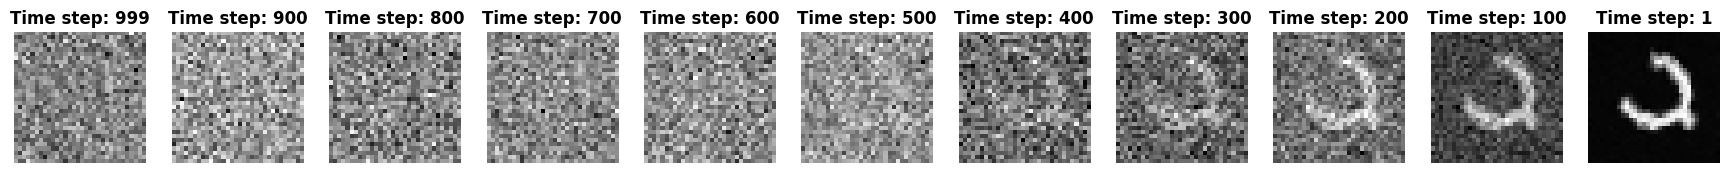

In [34]:
fig, axis = plt.subplots(nrows=1, ncols=11, figsize=(22, 2))

j = 0
for ax, s in zip(axis.ravel(), steps):
    ax.imshow(collect[s][0].detach().cpu().permute(1, 2, 0), cmap='gray')
    ax.set_title(f'Time step: {s}', fontweight='bold')
    ax.axis(False)
    j += 1

# Random sampling from noise

In [38]:
imgs = []
step = 999
for i in range(10):
    sampled_imgs, _ = ddpm.ddpm_sampling(model=model, 
                                         num_samples=5, 
                                         channels=1,
                                         sample_steps=[step],
                                         img_size=32,
                                         wanted_class=torch.tensor([i], device='cuda'))
    imgs.append(sampled_imgs)



1000it [00:07, 133.57it/s]
1000it [00:07, 134.35it/s]
1000it [00:07, 133.99it/s]
1000it [00:07, 134.23it/s]
1000it [00:07, 135.88it/s]
1000it [00:07, 135.84it/s]
1000it [00:07, 134.69it/s]
1000it [00:07, 135.81it/s]
1000it [00:07, 136.07it/s]
1000it [00:07, 135.93it/s]


(-0.5, 171.5, 341.5, -0.5)

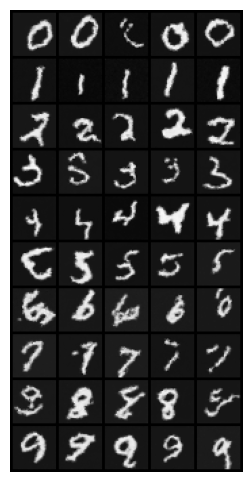

In [45]:
grid = make_grid(imgs.detach().cpu(), nrow=5, normalize=True)
plt.figure(figsize=(12, 6))
plt.imshow(grid.permute(1, 2, 0), cmap='gray')
plt.axis(False)

**TODO**
## EVALUATION

### 1st METHOD FID WITH IMPORTED LIBRARY

In [ ]:
# Import necessary libraries
import torch.nn.functional as F
from torchmetrics.image.fid import FrechetInceptionDistance

# Set the number of images to use for FID computation
N = 10000  # Increase this number for a more accurate FID score

# Generate N sampled images using your diffusion model


# De-normalize generated images to [0,1] and convert to uint8
sampled_imgs = torch.clamp(sampled_imgs, -1.0, 1.0)
sampled_imgs_denorm = (sampled_imgs + 1) / 2  # Now in [0,1]
sampled_imgs_denorm = sampled_imgs_denorm * 255  # Now in [0,255]
sampled_imgs_uint8 = sampled_imgs_denorm.to(torch.uint8)

# Repeat channels to get 3-channel images
sampled_imgs_rgb = sampled_imgs_uint8.repeat(1, 3, 1, 1)  # Shape: (N, 3, 32, 32)

# Resize images to 299x299 (required by InceptionV3)
sampled_imgs_resized = F.interpolate(sampled_imgs_rgb.float(), size=(299, 299), mode='bilinear', align_corners=False)
sampled_imgs_resized = sampled_imgs_resized.to(torch.uint8)

# Get N real images from the test dataset
real_images = []
for idx in range(N):
    img, _ = test_dataset[idx]
    real_images.append(img)
real_images = torch.stack(real_images)  # Shape: (N, 1, 32, 32)

# De-normalize real images to [0,1] and convert to uint8
real_images_denorm = real_images * 0.5 + 0.5  # Now in [0,1]
real_images_denorm = real_images_denorm * 255  # Now in [0,255]
real_images_uint8 = real_images_denorm.to(torch.uint8)

# Repeat channels to get 3-channel images
real_images_rgb = real_images_uint8.repeat(1, 3, 1, 1)

# Resize images to 299x299
real_images_resized = F.interpolate(real_images_rgb.float(), size=(299, 299), mode='bilinear', align_corners=False)
real_images_resized = real_images_resized.to(torch.uint8)

# Initialize the FID metric
fid = FrechetInceptionDistance(feature=2048, normalize=False).to(device)

# Compute FID: Feed real images
batch_size = 64
for i in range(0, real_images_resized.size(0), batch_size):
    real_batch = real_images_resized[i:i+batch_size].to(device)
    fid.update(real_batch, real=True)

# Compute FID: Feed generated images
for i in range(0, sampled_imgs_resized.size(0), batch_size):
    fake_batch = sampled_imgs_resized[i:i+batch_size].to(device)
    fid.update(fake_batch, real=False)

# Compute and print the FID score
fid_score = fid.compute()
print(f'FID score: {fid_score}')


In [ ]:
# Visualize a grid of generated images
grid_fake = make_grid(sampled_imgs_resized[:64].float() / 255, nrow=8, normalize=True)
grid_fake = grid_fake.permute(1, 2, 0).cpu()  # Move to CPU and permute dimensions
plt.figure(figsize=(8, 8))
plt.imshow(grid_fake)
plt.title('Generated Images')
plt.axis('off')
plt.show()

# Visualize a grid of real images
grid_real = make_grid(real_images_resized[:64].float() / 255, nrow=8, normalize=True)
grid_real = grid_real.permute(1, 2, 0).cpu()
plt.figure(figsize=(8, 8))
plt.imshow(grid_real)
plt.title('Real Images')
plt.axis('off')
plt.show()


### SECOND METHOD: TA suggestion

1. Feature Extraction Using a Pre-trained Classifier, to extract meaningful features from images to compare them effectively
2. Compute Features for Real Images
3. Compute Features for Generated Images with the same classifier
4. Calculate Statistics of Features: mean and covariance for generated and real images
5. Compute the FID Score

You compute the FID score by extracting features from both real and generated images using a classifier, calculating statistical summaries (mean and covariance) of these features, and then applying the FID formula to quantify the similarity between the two sets of images. This method allows you to evaluate how closely your model's generated images resemble real images in terms of high-level features captured by the classifier.

In [ ]:
class MNISTFeatureExtractor(torch.nn.Module):
    def __init__(self):
        super(MNISTFeatureExtractor, self).__init__()
        # Define a simple CNN suitable for MNIST
        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # 14x14
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),  # 7x7
        )
        self.classifier = torch.nn.Sequential(
            torch.nn.Flatten(),
            torch.nn.Linear(64 * 7 * 7, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10),
        )
        
    def forward(self, x):
        x = self.features(x)
        x_flat = x.view(x.size(0), -1)
        logits = self.classifier(x_flat)
        return logits, x_flat  # Return logits and features


In [ ]:
def train_mnist_classifier():
    # Define transformations
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    # Load MNIST dataset
    train_dataset = datasets.MNIST(root='./data_src', train=True, download=True, transform=transform)

    training_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)


    # Initialize the model, loss function, and optimizer
    model = MNISTFeatureExtractor().to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    model.train()
    for epoch in range(5):
        total_loss = 0
        for images, labels in tqdm(training_dataloader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(training_dataloader)}")
    return model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
mnist_classifier = train_mnist_classifier()


In [ ]:
def load_mnist_real_images():
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    test_dataset = datasets.MNIST(root='./data_src', train=False, download=True, transform=transform)
    test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
    return test_dataloader


In [ ]:
def compute_real_activations(model, dataloader):
    activations = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader):
            images = images.to(device)
            _, features = model(images)
            activations.append(features.cpu().numpy())
    activations = np.concatenate(activations, axis=0)
    return activations


In [ ]:
real_dataloader = load_mnist_real_images()
real_activations = compute_real_activations(mnist_classifier, real_dataloader)


In [ ]:
# Assuming sampled_imgs is of shape [N, 1, 32, 32]
# Resize images to 28x28 if necessary
generated_imgs_resized = F.interpolate(sampled_imgs, size=(28, 28), mode='bilinear', align_corners=False)
print(sampled_imgs.shape)


In [ ]:
def compute_fake_activations(model, images):
    model.eval()
    activations = []
    with torch.no_grad():
        batch_size = 64
        for i in tqdm(range(0, images.size(0), batch_size)):
            batch_images = images[i:i+batch_size].to(device)
            # Ensure images are in [0,1]
            batch_images = torch.clamp(batch_images, -1, 1)
            batch_images = (batch_images + 1) / 2  # Convert from [-1,1] to [0,1]
            _, features = model(batch_images)
            activations.append(features.cpu().numpy())
    activations = np.concatenate(activations, axis=0)
    return activations


In [ ]:
fake_activations = compute_fake_activations(mnist_classifier, generated_imgs_resized)


In [ ]:
def compute_statistics(activations):
    mu = np.mean(activations, axis=0)
    sigma = np.cov(activations, rowvar=False)
    return mu, sigma


In [ ]:
mu_real, sigma_real = compute_statistics(real_activations)
mu_fake, sigma_fake = compute_statistics(fake_activations)


In [ ]:
from scipy import linalg
def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance."""
    diff = mu1 - mu2

    # Product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1 @ sigma2, disp=False)
    if not np.isfinite(covmean).all():
        print("fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset) @ (sigma2 + offset))

    # Numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    fid_score = diff @ diff + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid_score


In [ ]:
fid_value = calculate_frechet_distance(mu_real, sigma_real, mu_fake, sigma_fake)
print(f"FID score: {fid_value}")


In [ ]:
from torchvision.utils import make_grid

# Convert images to [0,1] range for visualization
generated_imgs_vis = torch.clamp(generated_imgs_resized, 0, 1)
grid_fake = make_grid(generated_imgs_vis[:64], nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid_fake.permute(1, 2, 0).cpu().numpy())
plt.title('Generated Images')
plt.axis('off')
plt.show()

# Get a batch of real images
real_images, _ = next(iter(real_dataloader))
real_images = real_images.to(device)

grid_real = make_grid(real_images[:64], nrow=8, normalize=True)
plt.figure(figsize=(8, 8))
plt.imshow(grid_real.permute(1, 2, 0).cpu().numpy())
plt.title('Real Images')
plt.axis('off')
plt.show()



###  THIRD METHOD

It measures how similar the generated images are to real images by comparing their feature distributions extracted from a pre-trained neural network (InceptionV3). How ? 

1. Collect Real Images
2. Preprocess Images: Both real and generated images are resized to 299x299 pixels because InceptionV3 expects this input size. Convert to RGB,Normalize.
3. Extract Features Using InceptionV3
4. Compute Statistics of Activations for the real images and for the generated images: mean and covariance
5. Calculate the Fréchet Distance (FID Score)

##### Why This Method Works:
**Feature Comparison**: Instead of comparing images pixel by pixel, which doesn't capture high-level similarities, we compare the statistical properties of features extracted by a deep network trained on a large dataset.
**Capturing Perceptual Differences**: The InceptionV3 model's features capture important aspects of images that are relevant to human perception, making FID a good proxy for visual quality.

In [ ]:
N = 10000
test_dataset_no_transform = datasets.MNIST(
    root='./data_src', train=False, download=True, transform=None
)

indices = list(range(N))

In [ ]:
def preprocess_image(image):
    image = image.clamp(0, 1)  # Ensure pixel values are in [0, 1]
    image = transforms.ToPILImage()(image)
    image = transforms.Resize((299, 299))(image)
    image = transforms.ToTensor()(image)
    image = image.repeat(3, 1, 1)  # Convert grayscale to RGB by repeating channels
    image = transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    )(image)
    return image

In [ ]:
class GeneratedImagesDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images  # Tensor of shape (N, 1, 32, 32)
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, idx):
        img = self.images[idx]
        img = (img + 1) / 2  # Scale from [-1, 1] to [0, 1]
        img = preprocess_image(img)
        return img

In [ ]:
generated_dataset = GeneratedImagesDataset(sampled_imgs)
generated_dataloader = DataLoader(generated_dataset, batch_size=64, shuffle=False)

In [ ]:
class RealImagesDataset(torch.utils.data.Dataset):
    def __init__(self, base_dataset, indices):
        self.base_dataset = base_dataset  # MNIST dataset without transforms
        self.indices = indices  # Indices of images to include
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        base_idx = self.indices[idx]
        img_pil, _ = self.base_dataset[base_idx]
        img = transforms.ToTensor()(img_pil)  # Convert PIL image to tensor in [0, 1]
        img = preprocess_image(img)
        return img

In [ ]:
real_dataset = RealImagesDataset(test_dataset_no_transform, indices)
real_dataloader = DataLoader(real_dataset, batch_size=64, shuffle=False)

In [ ]:
import torchvision.models as models
from torchvision.models.inception import Inception_V3_Weights

model_inception = models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)
model_inception.fc = nn.Identity()  # Remove the final classification layer
model_inception.to(device)
model_inception.eval()

In [ ]:
def get_activation(dataloader, model, device='cpu'):
    """
    Given a dataloader and a model, generate an N x 2048-dimensional
    activation map for N data points in the dataloader.
    """
    model.to(device)
    model.eval()
    
    # Store activations
    pred_arr = np.zeros((len(dataloader.dataset), 2048))
    
    batch_size = dataloader.batch_size
    
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            batch = batch.to(device)
            pred = model(batch).cpu().numpy()
            start_idx = i * batch_size
            end_idx = start_idx + batch.shape[0]
            pred_arr[start_idx:end_idx] = pred
            
    return pred_arr

In [ ]:
def calculate_activation_statistics(dataloader, model, device='cpu'):
    """
    Get the mean vector and covariance matrix of the activation maps.
    """
    act = get_activation(dataloader, model, device)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

In [ ]:
from scipy import linalg

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Given means and covariance matrices of real and generated data,
    calculates the Fréchet Distance (FID score) between them.
    """
    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)
    
    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)
    
    diff = mu1 - mu2
    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    
    # Handle singularities
    if not np.isfinite(covmean).all():
        print("Adding epsilon to diagonal of covariance matrices to avoid singularities.")
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # Check for imaginary numbers
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    tr_covmean = np.trace(covmean)
    
    fid = diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    return fid

In [ ]:
mu_gen, sigma_gen = calculate_activation_statistics(
    generated_dataloader, model_inception, device=device
)

In [ ]:
mu_real, sigma_real = calculate_activation_statistics(
    real_dataloader, model_inception, device=device
)

In [ ]:
fid_value = calculate_frechet_distance(mu_gen, sigma_gen, mu_real, sigma_real)
print(f'FID Score: {fid_value}')

In [ ]:
# Convert images to [0, 1] range for visualization
sampled_imgs_0_1 = (sampled_imgs + 1) / 2
grid = make_grid(sampled_imgs_0_1[:64], nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
plt.title('Generated Images')
plt.axis('off')
plt.show()

real_images = []
for idx in range(64):
    img_pil, _ = test_dataset_no_transform[indices[idx]]
    img_tensor = transforms.ToTensor()(img_pil)
    real_images.append(img_tensor)

real_images = torch.stack(real_images)
grid_real = make_grid(real_images, nrow=8)

plt.figure(figsize=(8, 8))
plt.imshow(grid_real.permute(1, 2, 0).cpu().numpy())
plt.title('Real Images')
plt.axis('off')
plt.show()

# FID method from Slack

In [ ]:
import tensorflow as tf
import tensorflow_hub as tfhub
import tensorflow_gan as tfgan
import tensorflow as tf
def pack_images_to_tensor(path, img_size=None):
    """
    Given a path, pack all images into a tensor of shape (nb_images, height, width, channels)
    """
    nb_images = len(list(path.rglob("*.png")))
    print(f"Computing statistics for {nb_images} images")
    images = np.empty((nb_images, 28, 28, 1))  # TODO: Consider the RGB case
    for idx, f in enumerate(tqdm(path.rglob("*.png"))):
        img = Image.open(f)
        # resize if not the right size
        if img_size is not None and img.size[:2] != img_size:
            img = img.resize(
                size=(img_size[0], img_size[1]),
                resample=Image.BILINEAR,
            )
        img = np.array(img) / 255.0
        images[idx] = img[..., None]
    images_tf = tf.convert_to_tensor(images, dtype=tf.float32)
    return images_tf


def load_mnist():
    ds = datasets.MNIST(
        root="data",
        train=True,
        download=True,
        transform=transforms.Compose(
            [
                transforms.Resize(28),
                transforms.ToTensor(),
            ]
        ),
    )
    dl = data.DataLoader(ds, batch_size=60000, shuffle=False)
    x, y = next(iter(dl))
    x = torch.permute(x, (0, 2, 3, 1))
    return tf.convert_to_tensor(x.numpy())

def compute_activations(tensors, num_batches, classifier_fn):
    """
    Given a tensor of of shape (batch_size, height, width, channels), computes
    the activiations given by classifier_fn.
    """
    tensors_list = tf.split(tensors, num_or_size_splits=num_batches)
    stack = tf.stack(tensors_list)
    activation = tf.nest.map_structure(
        tf.stop_gradient,
        tf.map_fn(classifier_fn, stack, parallel_iterations=1, swap_memory=True),
    )
    return tf.concat(tf.unstack(activation), 0)


def compute_mnist_stats(mnist_classifier_fn):
    mnist = load_mnist()
    num_batches = 1
    activations1 = compute_activations(mnist, num_batches, mnist_classifier_fn)
    return activations1


def save_activations(activations, path, classifier_fn):
    np.save(path, activations.numpy())


activations_real = np.load("./data/mnist/activations_real.npy")
activations_real = tf.convert_to_tensor(activations_real, dtype=tf.float32)


print(f"Loading images of epoch {epoch_dir.name}")
epoch_images = pack_images_to_tensor(
    path=epoch_dir,
    )
print("Computing fake activations")
activation_fake = compute_activations(epoch_images, 1, classifier_fn)

print("Computing FID")
fid = tfgan.eval.frechet_classifier_distance_from_activations(
    activations_real, activation_fake
)
print(f"FID: {fid}")
    
